In [1]:
import numpy as np
import scipy.io as sio
import scipy.linalg as slinalg
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter1d as gf1d
import matplotlib.pyplot as plt
%matplotlib notebook
import sys
sys.path.append("../")
import ICP
import importlib
from PDE2D import *
from Mahalanobis import *
from SyntheticExamples import FlatTorusIdeal
from Kuramoto import *
from Mahalanobis import *
from LocalPCA import *
from ripser import ripser
from persim import plot_diagrams as plot_dgms

In [2]:
np.random.seed(1)

theta1 = 0
theta2 = np.pi/2
fac = 0.5
Win = 80
pd1 = (80, 1)
pd2 = (80, 1)
N = 5000
cropheight = 250 #195


delta = 2
n_points = 100
rank = 2
pca_dim = 120
maxeigs = 90
dMaxSqr = 1000


ks1 = KSSimulation(co_rotating=False, scale=(fac*7, fac/2), reldir='../')
ks1.crop(0, cropheight, 0, ks1.I.shape[1])
ks1.makeObservations(pd1, N)
ks1.thetas[0:N] = theta1
ks1.completeObservations()
ks1.resort_byraster()

ks2 = KSSimulation(co_rotating=False, scale=(fac*7, fac/2), reldir='../')
ks2.crop(0, cropheight, 0, ks2.I.shape[1])
ks2.makeObservations(pd2, N)
ks2.thetas[0:N] = theta2
ks2.completeObservations()
ks2.resort_byraster()

pdes = [ks1, ks2]
for ks in pdes:
    if pca_dim < ks.patches.shape[1]:
        ks.compose_with_dimreduction(dim=pca_dim)

Making 5000 observations of dimension (80, 1) on a grid of (250, 100)...
Elapsed time patch sampling: 0.101
Elapsed time patch sampling: 0.0976
Making 5000 observations of dimension (80, 1) on a grid of (250, 100)...
Elapsed time patch sampling: 0.109
Elapsed time patch sampling: 0.129


(5000, 80)
Computing Jacobians, rank = 2, maxiegs = 80...
0 of 5000
100 of 5000
200 of 5000
300 of 5000
400 of 5000
500 of 5000
600 of 5000
700 of 5000
800 of 5000
900 of 5000
1000 of 5000
1100 of 5000
1200 of 5000
1300 of 5000
1400 of 5000
1500 of 5000
1600 of 5000
1700 of 5000
1800 of 5000
1900 of 5000
2000 of 5000
2100 of 5000
2200 of 5000
2300 of 5000
2400 of 5000
2500 of 5000
2600 of 5000
2700 of 5000
2800 of 5000
2900 of 5000
3000 of 5000
3100 of 5000
3200 of 5000
3300 of 5000
3400 of 5000
3500 of 5000
3600 of 5000
3700 of 5000
3800 of 5000
3900 of 5000
4000 of 5000
4100 of 5000
4200 of 5000
4300 of 5000
4400 of 5000
4500 of 5000
4600 of 5000
4700 of 5000
4800 of 5000
4900 of 5000
Elapsed Time: 15.1
Computing Mahalanobis Distances...
Elapsed Time: 94.7
57.53350297901624
Building diffusion map matrix...
Elapsed Time: 0.55
Solving eigen system (sparsity 0.0147)...
Elapsed Time: 0.111
(5000, 80)
Computing Jacobians, rank = 2, maxiegs = 80...
0 of 5000
100 of 5000
200 of 5000
300 of 

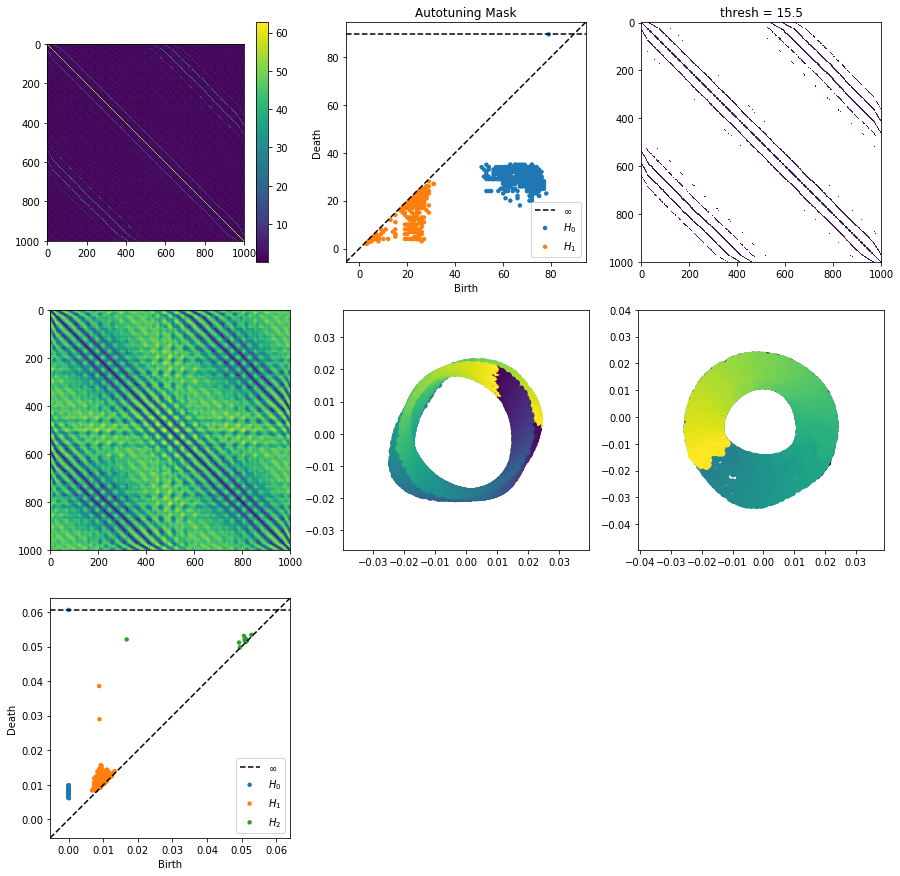

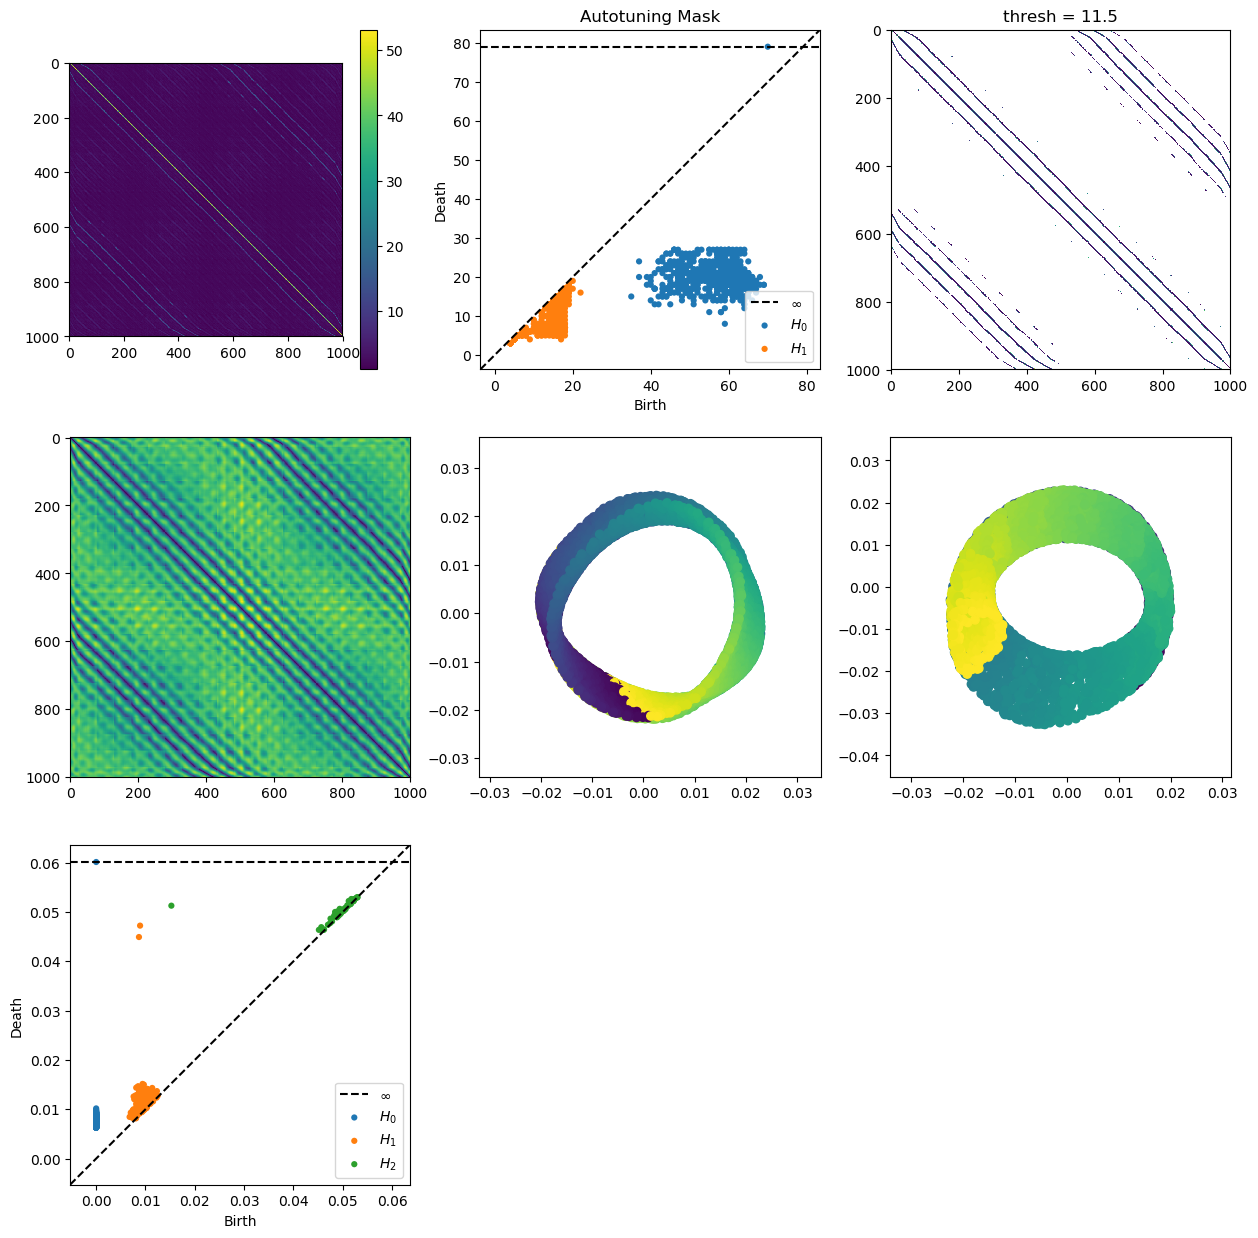

In [3]:
## Perform diffusion maps on each set individually
Ys = []
alldgms = []
for i in range(2):
    ksi = pdes[i]
    print(ksi.patches.shape)
    
    ## Step 1: Compute Mahalanobis and autotune mask using TDA
    res = getMahalanobisDists(ksi.patches, ksi.get_mahalanobis_ellipsoid, delta, \
                          n_points=n_points, rank=rank, maxeigs=maxeigs)
    DSqri, maskidx = res["gamma"], res["maskidx"]
    dgms = ripser(-maskidx, distance_matrix=True, maxdim=1, n_perm=600)['dgms']
    for i in range(len(dgms)):
        dgms[i] *= -1
    plt.figure(figsize=(15, 15))
    plt.subplot(331)
    plt.imshow(largeimg(np.array(res["maskidx"], dtype=float)))
    plt.colorbar()
    plt.subplot(332)
    plot_dgms(dgms)
    plt.title("Autotuning Mask")
    I1 = dgms[1]
    idxs = np.argsort(I1[:, 1]-I1[:, 0])
    thresh = np.mean(I1[idxs[1], :])
    mask = np.array(maskidx >= thresh, dtype=float)
    plt.subplot(333)
    plt.imshow(largeimg(DSqri, mask), cmap='viridis')
    plt.title("thresh = %.3g"%thresh)
    
    ## Step 2: Perform diffusion maps
    epsi = dMaxSqr*np.max(DSqri)*1e-3
    print(epsi)
    Yi = getDiffusionMap(DSqri, eps=epsi, distance_matrix=True, mask=mask, neigs=8, flip=True, thresh=0)
    Ys.append(Yi)
    
    plt.subplot(334)
    plt.imshow(largeimg(getSSM(Yi)), cmap='viridis')
    plt.subplot(335)
    plt.scatter(Yi[:, 0], Yi[:, 1], c=ksi.Xs, cmap='viridis')
    plt.subplot(336)
    plt.scatter(Yi[:, 2], Yi[:, 3], c=ksi.Ts, cmap='viridis')
    
    ## Step 3: Compute TDA on final result
    plt.subplot(337)
    dgmsfinal = ripser(Yi, n_perm=500, maxdim=2)['dgms']
    plot_dgms(dgmsfinal)
    alldgms.append(dgmsfinal)

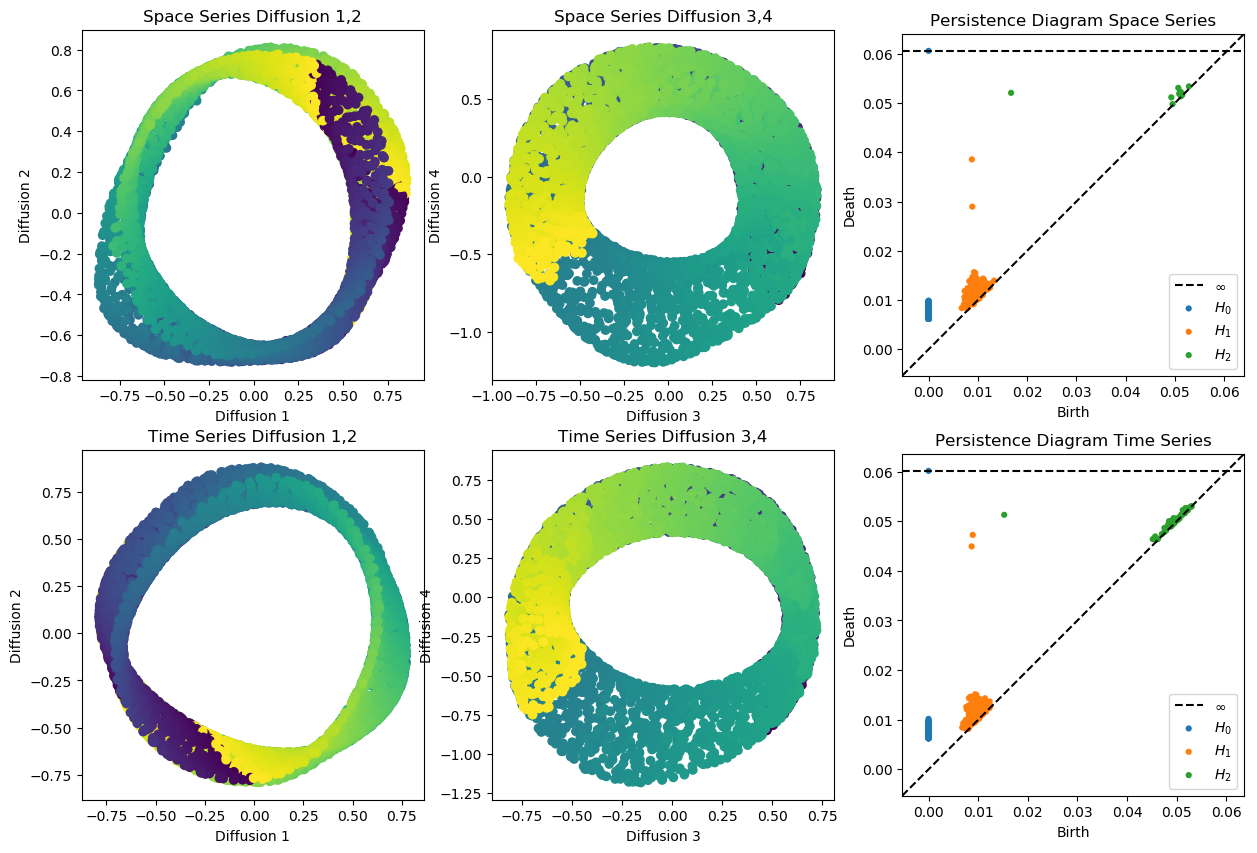

In [39]:
plt.figure(figsize=(15, 10))
labels = ["Space Series", "Time Series"]
for i in range(2):
    plt.subplot(2, 3, i*3+1)
    plt.scatter(Ys[i][:, 0], Ys[i][:, 1], c=pdes[i].Xs, cmap='viridis')
    plt.xlabel("Diffusion 1")
    plt.ylabel("Diffusion 2")
    plt.title("%s Diffusion 1,2"%labels[i])
    plt.subplot(2, 3, i*3+2)
    plt.scatter(Ys[i][:, 2], Ys[i][:, 3], c=pdes[i].Ts, cmap='viridis')
    plt.xlabel("Diffusion 3")
    plt.ylabel("Diffusion 4")
    plt.title("%s Diffusion 3,4"%labels[i])
    plt.subplot(2, 3, i*3+3)
    plot_dgms(alldgms[i])
    plt.title("Persistence Diagram %s"%labels[i])
plt.savefig("HorizontalToVertical_DiffusionTDA.svg", bbox_inches='tight')

1
rmse=0.0744


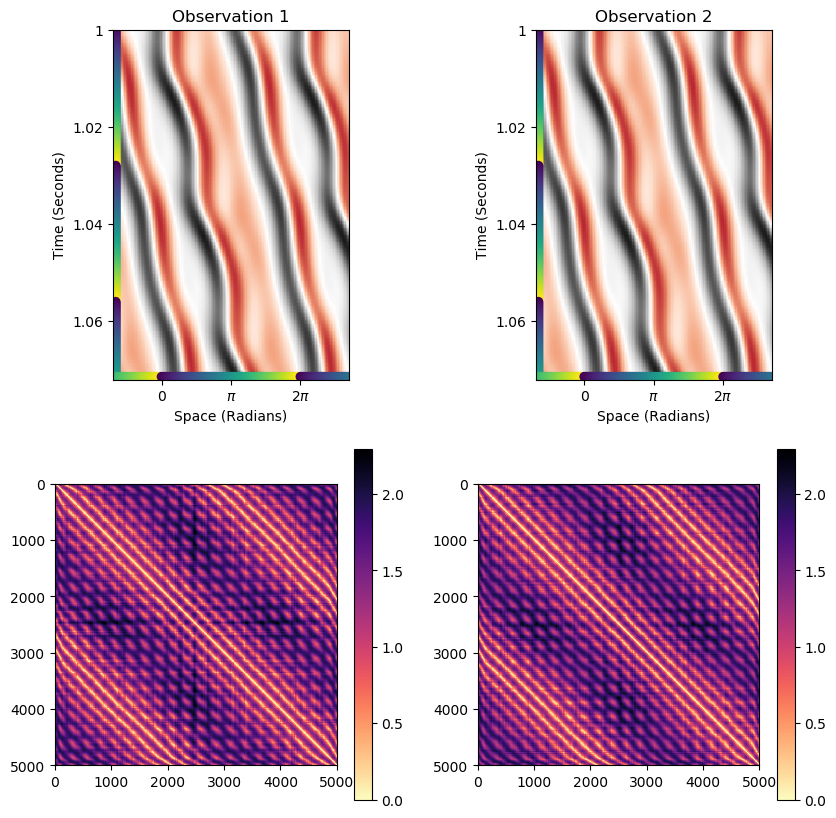

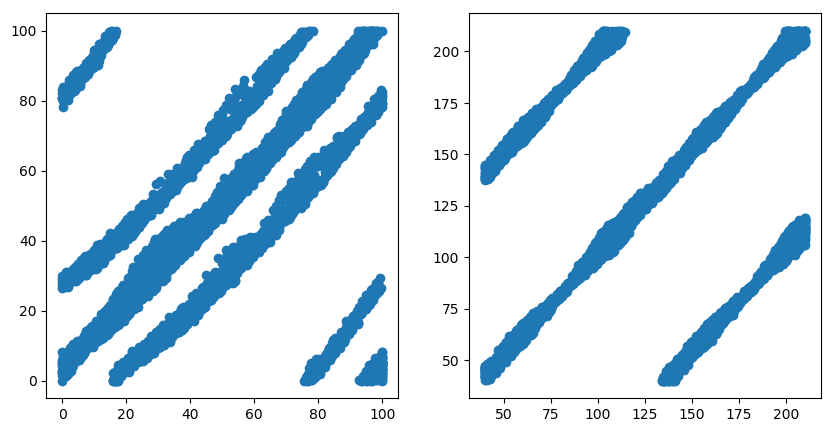

In [5]:
## Align the two patch sets using some correspondences
from SyntheticExamples import FlatTorusIdeal
importlib.reload(ICP)

seed=1
#for seed in range(20):
np.random.seed(seed)
ncorresp = 4
x1 = np.array([pdes[0].Xs, pdes[0].Ts])
x2 = np.array([pdes[1].Xs, pdes[1].Ts])
D = ICP.getCSM(x1, x2)
D = np.argmin(D, 1)
idx = np.random.permutation(np.arange(Ys[0].shape[0]))[0:ncorresp]
corresp = np.zeros((ncorresp, 2), dtype=int)
corresp[:, 0] = idx
corresp[:, 1] = D[idx]
weights = np.ones(Ys[0].shape[0])
weights[idx] = 2000

print(seed)
idxMin = ICP.doICP_PDE2D(pdes[0], Ys[0][:, 0:4], pdes[1], Ys[1][:, 0:4], corresp=corresp, weights=weights, \
                         initial_guesses=1, do_plot=False, MaxIters=200)['idxMin']

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(x1[0, :], x2[0, idxMin[-1]])
plt.subplot(122)
plt.scatter(x1[1, :], x2[1, idxMin[-1]])

In [6]:
pdes[1].f_patch = lambda x: x
pdes[1].completeObservations()

Elapsed time patch sampling: 0.113


(1788, 2)


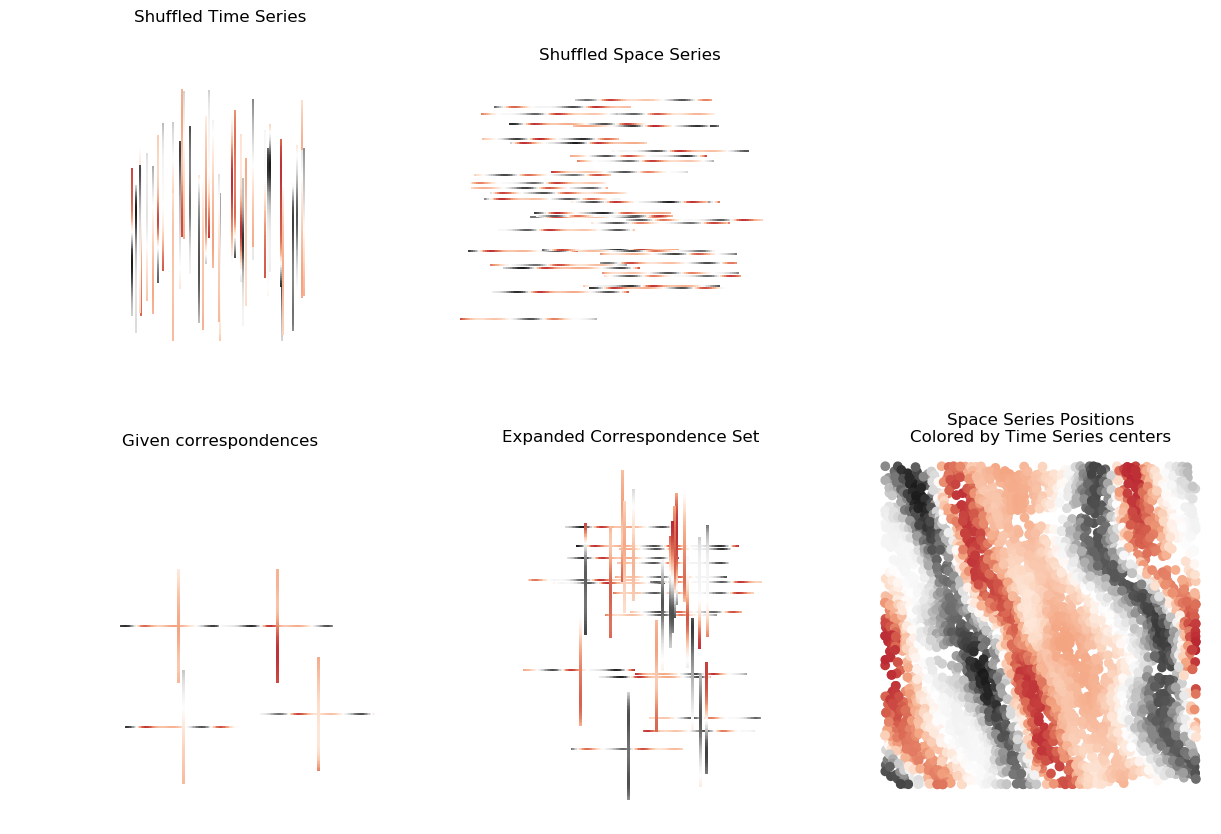

In [58]:
import matplotlib.transforms as mtransforms

plt.figure(figsize=(15, 10))
## Subplot 1: Shuffled line segments on the left, patches on the right

vmax = np.max(np.abs(pdes[0].I))
vmin = -vmax
ax = plt.subplot(231)
N = 40
locs = np.array([pdes[1].Xs, pdes[1].Ts]).T
locs = locs[pdes[1].Ts <= pdes[1].I.shape[1], :]
#idxs, _ = getGreedyPerm(locs, N)
idxs = np.random.permutation(locs.shape[0])
locs = locs[idxs, :]
idxs = np.random.permutation(pdes[0].Xs.size)

for i in range(N):
    p = np.reshape(pdes[0].patches[idxs[i], :], pdes[0].pd)
    im = ax.imshow(p, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m = np.eye(3)
    u = locs[i, :]
    m[0:2, 2] = u
    c = np.cos(pdes[0].thetas[i])
    s = np.sin(pdes[0].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m)
    im.set_transform(trans + ax.transData)
plt.xlim([0, 100])
plt.ylim([200, 10])
plt.axis('off')
plt.title("Shuffled %s"%labels[1])


ax = plt.subplot(232)
locs = np.array([pdes[0].Xs, pdes[0].Ts]).T
locs = locs[pdes[1].Ts <= pdes[1].I.shape[1], :]
idxs = np.random.permutation(locs.shape[0])
locs = locs[idxs, :]
print(locs.shape)
locs -= np.mean(locs, 0)
idxs = np.random.permutation(pdes[1].Xs.size)
for i in range(N):
    p = np.reshape(pdes[1].patches[idxs[i], :], pdes[1].pd)
    im = ax.imshow(p, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m = np.eye(3)
    u = np.array(locs[i, :])
    u[1] *= 2
    m[0:2, 2] = u
    c = np.cos(pdes[1].thetas[i])
    s = np.sin(pdes[1].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m)
    im.set_transform(trans + ax.transData)
plt.xlim([-50, 150])
plt.ylim([80, -80])
plt.axis('off')
plt.title("Shuffled %s"%labels[0])

locs = np.array([pdes[0].Xs, pdes[0].Ts]).T
locs = locs[pdes[1].Ts <= pdes[1].I.shape[1], :]
idxs, _ = getGreedyPerm(locs, N)
locs = locs[idxs, :]
ax = plt.subplot(234)
for i in range(corresp.shape[0]):
    i1, i2 = corresp[i, :]
    p1 = np.reshape(pdes[0].patches[i1, :], pdes[0].pd)
    p1 = np.concatenate((p1, p1), axis=1)
    p2 = np.reshape(pdes[1].patches[i2, :], pdes[1].pd)
    # Draw line segment type 1
    im = ax.imshow(p2, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[1, 2] = -p2.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i, :]
    c = np.cos(pdes[1].thetas[i])
    s = np.sin(pdes[1].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)
    
    # Now draw corresponding line segment on top of it
    im = ax.imshow(p1, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[1, 2] = -p1.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i, :]
    c = np.cos(pdes[0].thetas[i])
    s = np.sin(pdes[0].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)
plt.xlim([-90, 150])
plt.ylim([160, -80])
plt.axis('off')
plt.title("Given correspondences")

ax = plt.subplot(235)
N = 20
locs = np.array([pdes[1].Xs, pdes[1].Ts]).T
#idxs, _ = getGreedyPerm(locs, N)
idxs = np.random.permutation(locs.shape[0])
correspfinal = idxMin[-1]
for i1 in idxs[0:N]:
    i2 = correspfinal[i1]
    p2 = np.reshape(pdes[1].patches[i2, :], pdes[1].pd)
    # Draw line segment type 1
    im = ax.imshow(p2, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[1, 2] = -p2.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i1, :]
    c = np.cos(pdes[1].thetas[i])
    s = np.sin(pdes[1].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)

for i1 in idxs[0:N]:
    p1 = np.reshape(pdes[0].patches[i1, :], pdes[0].pd)
    p1 = np.concatenate((p1, p1), axis=1)
    # Now draw corresponding line segment on top of it
    im = ax.imshow(p1, interpolation='none', alpha=1, cmap='RdGy', vmin=vmin, vmax=vmax)
    m1 = np.eye(3)
    m1[1, 2] = -p1.shape[0]/2
    m = np.eye(3)
    m[0:2, 2] = locs[i1, :]
    c = np.cos(pdes[0].thetas[i])
    s = np.sin(pdes[0].thetas[i])
    m[0, 0] = c
    m[0, 1] = s
    m[1, 0] = -s
    m[1, 1] = c
    trans = mtransforms.Affine2D()
    trans.set_matrix(m.dot(m1))
    im.set_transform(trans + ax.transData)
    
plt.xlim([-75, 150])
plt.ylim([240, -10])
plt.axis('off')
plt.title("Expanded Correspondence Set")


plt.subplot(236)
f_interp = pdes[0].getInterpolator()
patch_centers = f_interp(pdes[0].Ts.flatten(), pdes[0].Xs.flatten(), grid=False)
plt.scatter(pdes[1].Xs[correspfinal], pdes[1].Ts[correspfinal], c=patch_centers, cmap='RdGy', vmin=vmin, vmax=vmax)
plt.gca().invert_yaxis()
plt.axis('off')
plt.title("%s Positions\nColored by %s centers"%tuple(labels))

plt.savefig("HorizontalToVerticalAligned.svg", bbox_inches='tight')